## Training `segy`-baseline model

In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import os
import sys
import warnings
import logging
import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob
from tqdm import trange

sys.path.append('../repos/seismiqb/')
from seismiqb.batchflow import Pipeline, FilesIndex
from seismiqb.batchflow import B, V, C, L, F, D, P, R, W
from seismiqb.batchflow.models.tf import *
from seismiqb.batchflow.models.tf.layers import conv_block
from seismiqb import SeismicCropBatch, SeismicGeometry, SeismicCubeset#, Horizon
from seismiqb import plot_loss
# from utils import *

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

* check out the dataset of 2d-`segy`s:

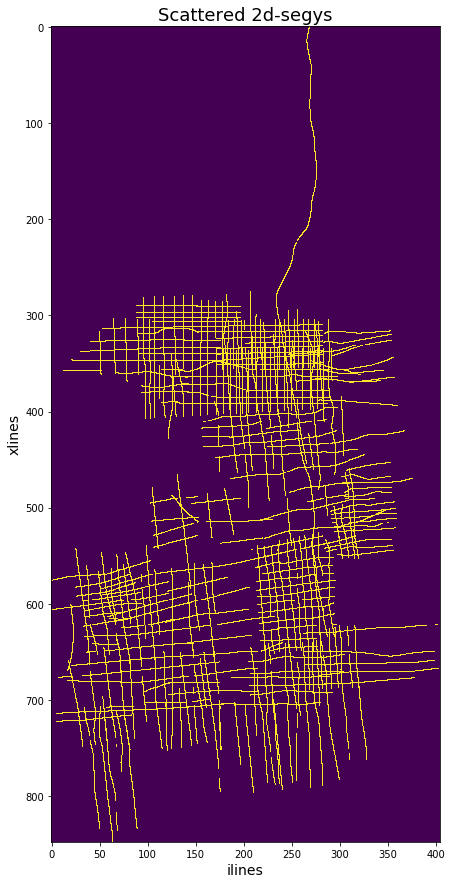

In [199]:
from aux import show_scatter
show_scatter(cdp_pairs_, x_range, y_range, figsize=(10, 15))

* check out a `segy`-trace

In [2]:
paths_cubes = ['/notebooks/2d_seismic_h5/Line_FXNAT1141100011_LMK/Line_FXNAT1141100011_LMK.hdf5']
dsi = FilesIndex(path=paths_cubes, no_ext=True)
ds = SeismicCubeset(dsi)

In [3]:
ds.load('/horizons/*', filter_zeros=False, bins=np.array([1, 100, 100]))

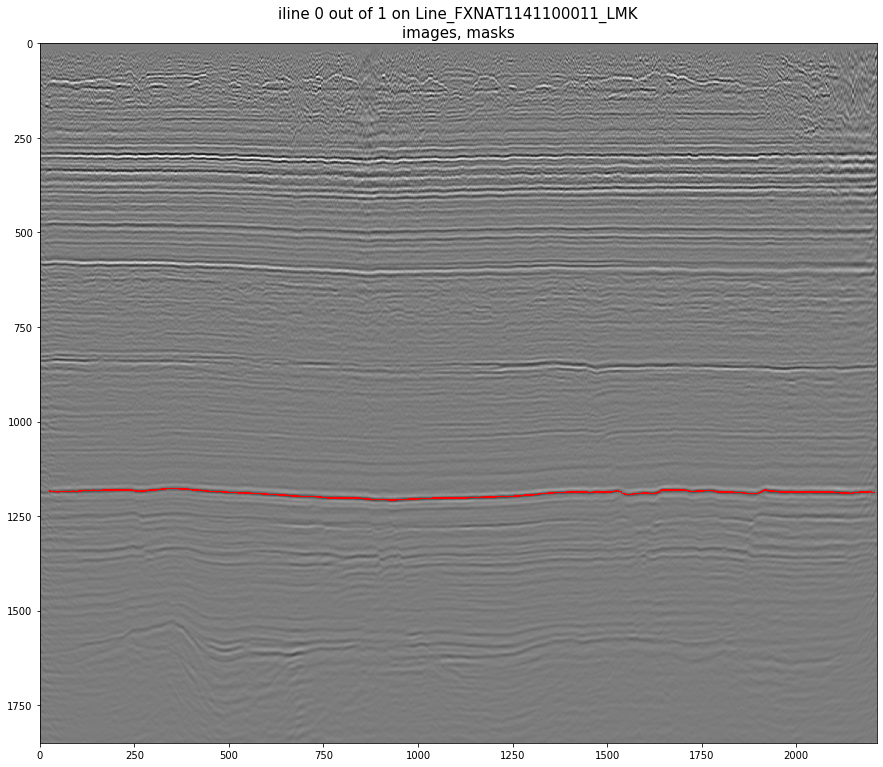

In [5]:
ds.show_slide()

## Training baseline-model

* check that crop-generation works correctly:

In [47]:
# Global constants
NUM_CROPS = 8
CROP_SHAPE = (1, 256, 256) # i, x, h
EPOCHS = 10000

In [7]:
train_template = (Pipeline()
                  # Load data/masks
                  .load_component(src=[D('geometries'), D('labels')],
                                  dst=['geometries', 'labels'])
                  .crop(points=D('sampler').sample(1),
                        shape=np.array(CROP_SHAPE))
                  .load_cubes(dst='images')
                  .create_masks(dst='masks', width=2)
                  .rotate_axes(src=['images', 'masks']))

# Add dataset to pipeline
train_pipeline = train_template << ds

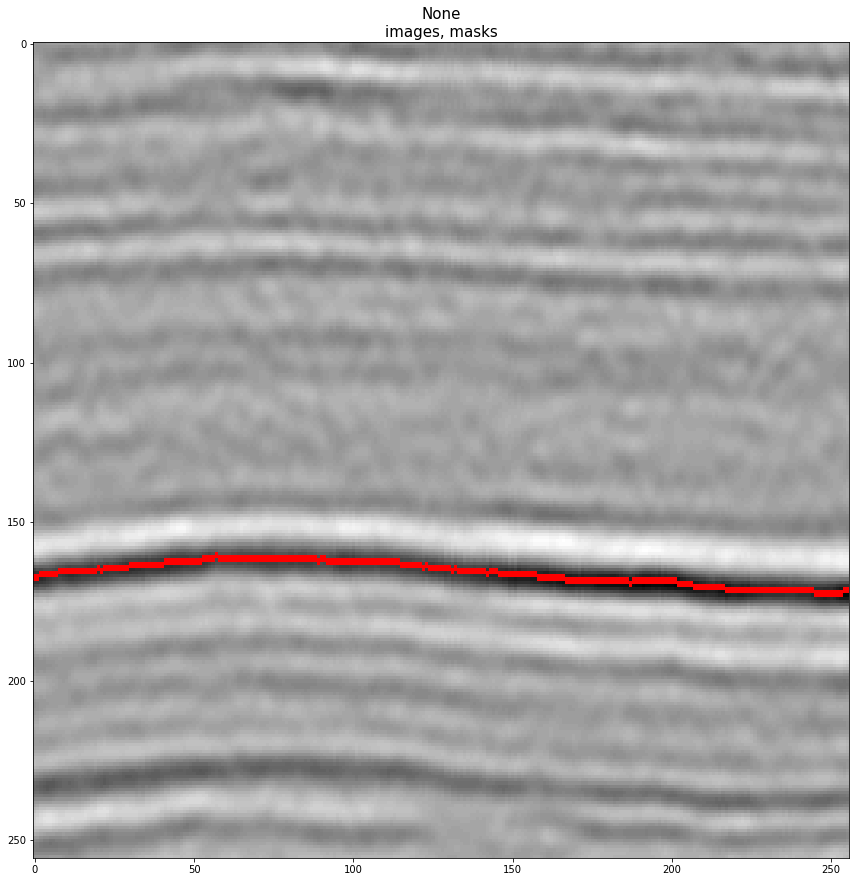

In [8]:
b = train_pipeline.next_batch(1)
b.plot_components('images', 'masks')

* make a dataset with correct horizon-labels for training 

In [9]:
all_paths = glob('/notebooks/2d_seismic_h5/*')
paths_to_labelled = []

In [10]:
for path in all_paths:
    if 'horizons' in os.listdir(path):
        paths_to_labelled.append(path)

In [11]:
len(all_paths)

381

In [12]:
len(paths_to_labelled)

93

In [13]:
paths_to_cubes = []
for path in paths_to_labelled:
    name = os.path.split(path)[-1]
    paths_to_cubes.append(path + '/' + name + '.hdf5')

* checker-cycle

In [14]:
good_ones = []
bad_ones = []
for path in paths_to_cubes:
    dsi_ = FilesIndex(path=path, no_ext=True)
    ds_ = SeismicCubeset(dsi_)
    try:
        ds_.load('/horizons/*', filter_zeros=False, bins=np.array([1, 100, 100]))
        good_ones.append(path)
    except:
        bad_ones.append(path)

In [15]:
len(good_ones)

70

In [16]:
len(bad_ones)

23

In [17]:
dsi = FilesIndex(path=good_ones, no_ext=True)
ds = SeismicCubeset(dsi)
ds.load('/horizons/*', filter_zeros=False, bins=np.array([1, 100, 100]))

## Training baseline model

In [19]:
class ED(EncoderDecoder):
    @classmethod
    def head(cls, inputs, targets, name='head', **kwargs):
        kwargs = cls.fill_params('head', **kwargs)

        with tf.variable_scope(name):
            x = TFModel.head(inputs, name, **kwargs)
            channels = cls.num_channels(targets)
            if cls.num_channels(x) != channels:
                args = {**kwargs, **dict(layout='c', kernel_size=1, filters=channels)}
                x = conv_block(x, name='conv1x1', **args)
                x = tf.expand_dims(x, axis=-1, name='expand')
        return x


# Model configuration
model_config = {
    # Shapes and orders
    'inputs/images/shape': (None, None, CROP_SHAPE[0]),
    'inputs/masks/shape': (None, None, CROP_SHAPE[0], 1), 
    'initial_block/inputs': 'images',
    'common/data_format': 'channels_last',
    # Model layout
    'initial_block': {'layout': 'pp'},
    'body/encoder': {'num_stages': 3,
                     'blocks': {'base': Inception_v4.inception_a_block,
                                'filters': [[32, 16], [48, 32], [64, 48]]}},
    'body/embedding': {'base': Inception_v4.inception_c_block,
                       'filters': [32, 48, 64, 96]},
    'body/decoder': {'num_stages': 5,
                     'blocks': {'layout':'cna',
                                'filters': [32, 16, 8, 6, 4]}},
    'output': 'sigmoid',
    # Train configuration
    'loss': 'dice',
    'optimizer': 'Adam',
    'decay': {'name': 'invtime',
              'learning_rate': 0.01,
              'decay_rate': 1,
              'decay_steps': 100},
    'microbatch': 4,
}

pipeline_config = {
    'model': ED,
    'model_config': model_config,
}

In [48]:
train_template = (Pipeline(config=pipeline_config)
                  # Initialize pipeline variables and model
                  .init_variable('loss_history', [])
                  .init_model('dynamic', C('model'), 'ED', C('model_config'))
                  # Load data/masks
                  .load_component(src=[D('geometries'), D('labels')],
                                  dst=['geometries', 'labels'])
                  .crop(points=D('sampler').sample(NUM_CROPS),
                        shape=CROP_SHAPE)
                  .load_cubes(dst='images')
                  .create_masks(dst='masks', width=2)
                  .rotate_axes(src=['images', 'masks'])
                  .scale(mode='normalize', src='images')
                  # Augmentations
                  .additive_noise(scale=0.005,
                                  src='images', dst='images', p=0.2)
                  .rotate(angle=P(R('uniform', -30, 30)),
                          src=['images', 'masks'], p=0.4)
                  .scale_2d(scale=P(R('uniform', 0.7, 1.3)),
                            src=['images', 'masks'], p=0.4)
                  .elastic_transform(alpha=P(R('uniform', 35, 45)), sigma=P(R('uniform', 4, 4.5)),
                                     src=['images', 'masks'], p=0.2)
                  # Training
                  .add_axis(src='masks', dst='masks')
                  .train_model('ED', 
                               fetches='loss',
                               images=B('images'),
                               masks=B('masks'),
                               save_to=V('loss_history', mode='a')))

# Add dataset to pipeline
train_pipeline = train_template << ds

In [ ]:
# Training loop. Allows to see progress (value of loss)
train_pipeline.run(D('size'), n_iters=EPOCHS, bar=True,
                   bar_desc=W(V('loss_history')[-1].format('Loss is: {:7.7}')))


Loss is: -0.4786791:   1%|▏         | 132/10000 [00:58<38:50,  4.24it/s]

## Testing on slices from `dataset`

In [ ]:
area_ = scatter_on_area(cdp_pairs, cdp_xs, cdp_ys, scale=300)
fig, ax = plt.subplots(figsize=(10, 15))
ax.imshow(area_)

In [91]:
from aux import scatter_on_area, get_cdps_from_segys

In [93]:
all_segypaths = glob('/notebooks/2d_seismic_fixed/segys/*.segy')

In [102]:
def get_name(fullpath):
    return os.path.splitext(os.path.split(fullpath)[1])[0]

In [104]:
labeled_names = [get_name(fullpath) for fullpath in good_ones]

* scatter those segys used for training

In [110]:
# get range
cdp_pairs_, cdp_xs_, cdp_ys_ = get_cdps_from_segys(all_segypaths)
x_range = min(cdp_xs_), max(cdp_xs_)
y_range = min(cdp_ys_), max(cdp_ys_)

In [ ]:
cdp_pairs, cdp_xs, cdp_ys = get_cdps_from_segys([path for path in all_segypaths if get_name(path) in labeled_names])

In [125]:
def show_scatter(pairs, x_range, y_range, figsize=(10, 15)):
    area = scatter_on_area(np.array(pairs), x_range=x_range, y_range=y_range, scale=300)
    fig, ax = plt.subplots(figsize=(10, 15))
    ax.imshow(area)
    plt.xlabel('ilines', fontdict={'fontsize': 14})
    plt.ylabel('xlines', fontdict={'fontsize': 14})
    plt.title('Scattered 2d-segys', fontdict={'fontsize': 18})

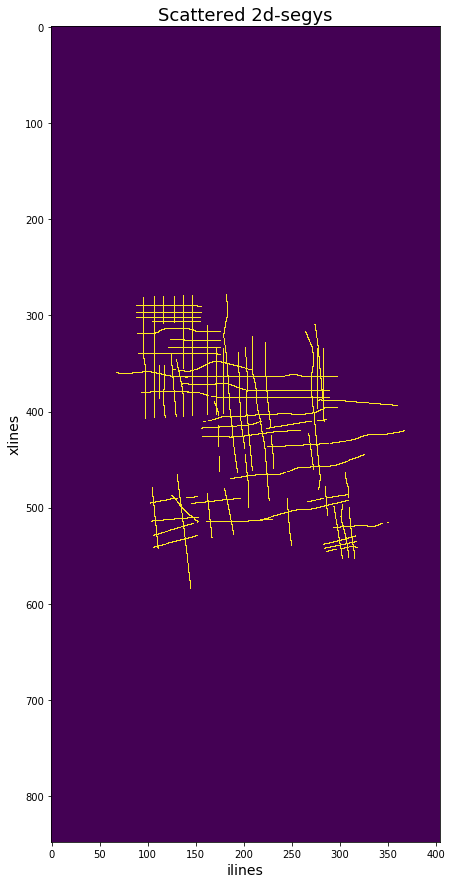

In [127]:
show_scatter(cdp_pairs, x_range, y_range, figsize=(10, 15))

* scatter other segys

In [130]:
other_segynames = [path for path in all_segypaths if get_name(path) not in labeled_names]

In [145]:
random_set = np.random.choice(other_segynames, 10)

In [150]:
cdp_pairs, cdp_xs, cdp_ys = get_cdps_from_segys(other_segynames)

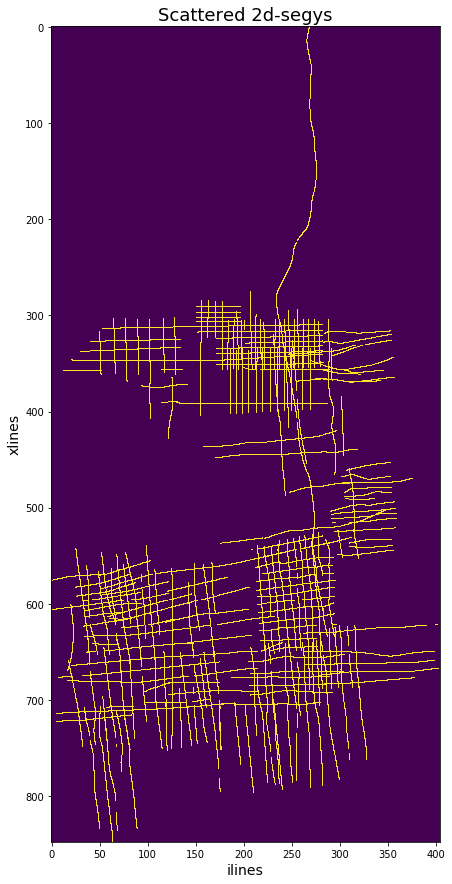

In [151]:
show_scatter(cdp_pairs, x_range, y_range, figsize=(10, 15))

In [56]:
test_dsi = FilesIndex(path=bad_ones, no_ext=True)
test_ds = SeismicCubeset(dsi)
test_ds.load(None, filter_zeros=False, bins=np.array([1, 100, 100]))

INFO:geometry_logger:Geometry for cube: /notebooks/2d_seismic_h5/Line_FXNAT114110040_LMK/Line_FXNAT114110040_LMK.hdf5
                   Time delay and sample rate: -12, 2.0
                   Number of ilines: 1
                   Number of xlines: 665
                   Depth of one trace is: 1850
                   ilines range from 0 to 0
                   xlines range from 0 to 664
INFO:geometry_logger:Geometry for cube: /notebooks/2d_seismic_h5/Line_FXNAT1141100411_LMK/Line_FXNAT1141100411_LMK.hdf5
                   Time delay and sample rate: -12, 2.0
                   Number of ilines: 1
                   Number of xlines: 653
                   Depth of one trace is: 1850
                   ilines range from 0 to 0
                   xlines range from 0 to 652
INFO:geometry_logger:Geometry for cube: /notebooks/2d_seismic_h5/Line_FXNAT1141100318_LMK/Line_FXNAT1141100318_LMK.hdf5
                   Time delay and sample rate: -12, 2.0
                   Number of ilines: 1
 

In [65]:
test_ds.geometries[test_ds.indices[2]]

Inferred geometry for Line_FXNAT1141100318_LMK.hdf5: (1x1629x1850)

In [70]:
test_ds.make_grid(test_ds.indices[2], CROP_SHAPE, [0, 1], [0, 1629], [0, 1850])

In [71]:
# Pipeline template. Can be used multiple times (for different datasets)
val_template = (Pipeline()
                # Initialize everything
                .init_variable('result_images', init_on_each_run=[])
                .init_variable('result_preds', init_on_each_run=[])
                .import_model('ED', train_pipeline)              
                # Load data
                .load_component(src=D('geometries'), dst='geometries')
                .crop(points=D('grid_gen')(),
                      shape=CROP_SHAPE)
                .load_cubes(dst='images')
                .rotate_axes(src='images')
                .scale(mode='normalize', src='images')
                # Predict with model, then aggregate
                .predict_model('ED', 
                               fetches=['images', 'predictions'],
                               images=B('images'),
                               save_to=[V('result_images', mode='e'),
                                        V('result_preds', mode='e')])
                .assemble_crops(src=V('result_preds'), dst='assembled_pred',
                                  grid_info=D('grid_info'))
                .assemble_crops(src=V('result_images'), dst='assembled_img',
                                  grid_info=D('grid_info'))
                )

In [72]:
%%time
val_pipeline = val_template << test_ds

for _ in trange(test_ds.grid_iters):
    batch = val_pipeline.next_batch(D('size'), n_epochs=None)


100%|██████████| 4/4 [00:00<00:00, 10.43it/s]

CPU times: user 366 ms, sys: 143 ms, total: 509 ms
Wall time: 388 ms


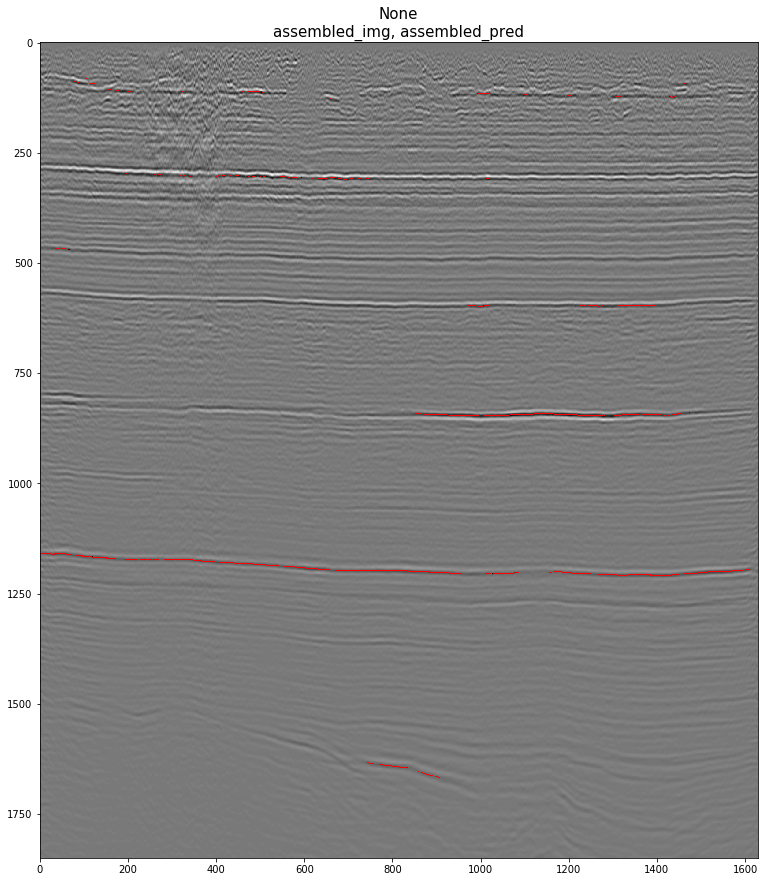

In [73]:
batch.plot_components('assembled_img', 'assembled_pred', idx=None, order_axes=(1, 2, 0))

In [77]:
test_ds.mask_to_horizons(batch.assembled_pred)

## More plots and examples

* slice-plots

In [149]:
test_names = [get_name(fullpath) for fullpath in random_set]

In [182]:
h5_test_paths = [fullpath for fullpath in glob('/notebooks/2d_seismic_h5/*/*.hdf5') if get_name(fullpath) in test_names]

In [191]:
test_ds.geometries[test_ds.indices[i]].cube_shape

array([   1,  732, 2000])

In [189]:
test_dsi = FilesIndex(path=h5_test_paths, no_ext=True)
test_ds = SeismicCubeset(test_dsi)
test_ds.load(None, filter_zeros=False, bins=np.array([1, 100, 100]))

INFO:geometry_logger:Geometry for cube: /notebooks/2d_seismic_h5/27840112_invPol-22_uvz/27840112_invPol-22_uvz.hdf5
                   Time delay and sample rate: -200, 2.0
                   Number of ilines: 1
                   Number of xlines: 732
                   Depth of one trace is: 2000
                   ilines range from 0 to 0
                   xlines range from 0 to 731
INFO:geometry_logger:Geometry for cube: /notebooks/2d_seismic_h5/Line_48183024_LMK/Line_48183024_LMK.hdf5
                   Time delay and sample rate: 8, 2.0
                   Number of ilines: 1
                   Number of xlines: 704
                   Depth of one trace is: 1772
                   ilines range from 0 to 0
                   xlines range from 0 to 703
INFO:geometry_logger:Geometry for cube: /notebooks/2d_seismic_h5/2784027_invPol-22_uvz/2784027_invPol-22_uvz.hdf5
                   Time delay and sample rate: -600, 2.0
                   Number of ilines: 1
                   Numb


100%|██████████| 2/2 [00:00<00:00,  8.96it/s]


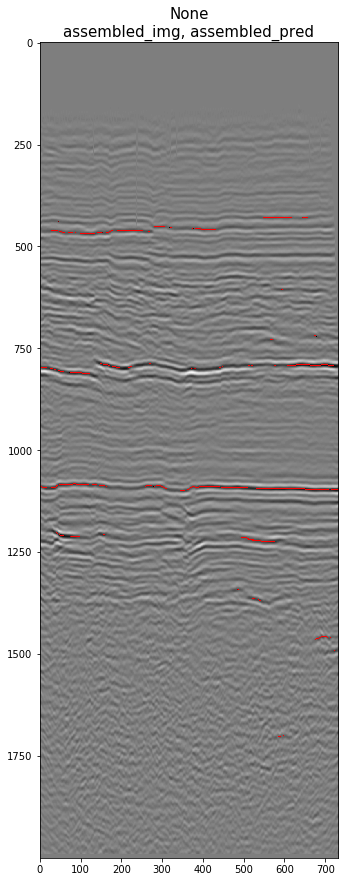


100%|██████████| 2/2 [00:00<00:00,  7.29it/s]


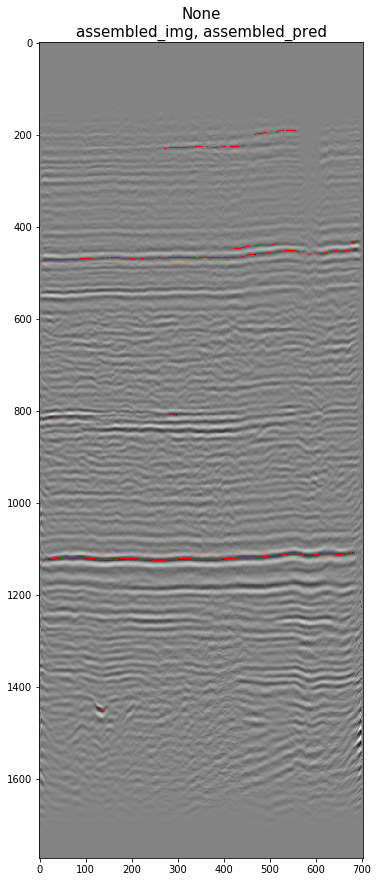


100%|██████████| 2/2 [00:00<00:00, 12.66it/s]


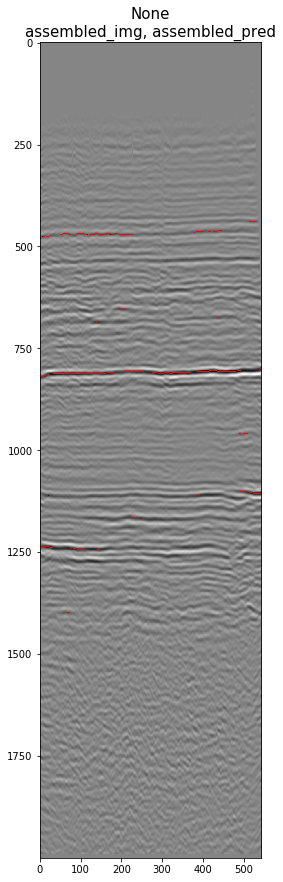


100%|██████████| 4/4 [00:00<00:00,  7.70it/s]


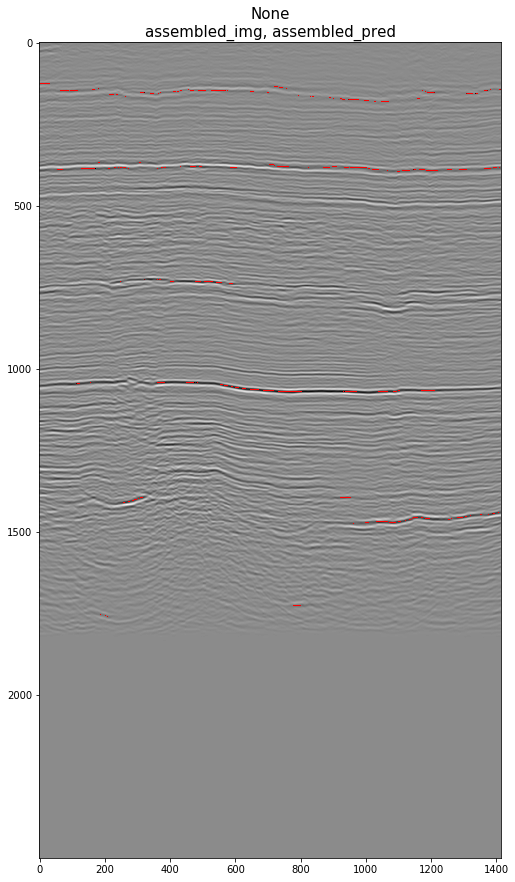


100%|██████████| 3/3 [00:00<00:00,  8.77it/s]


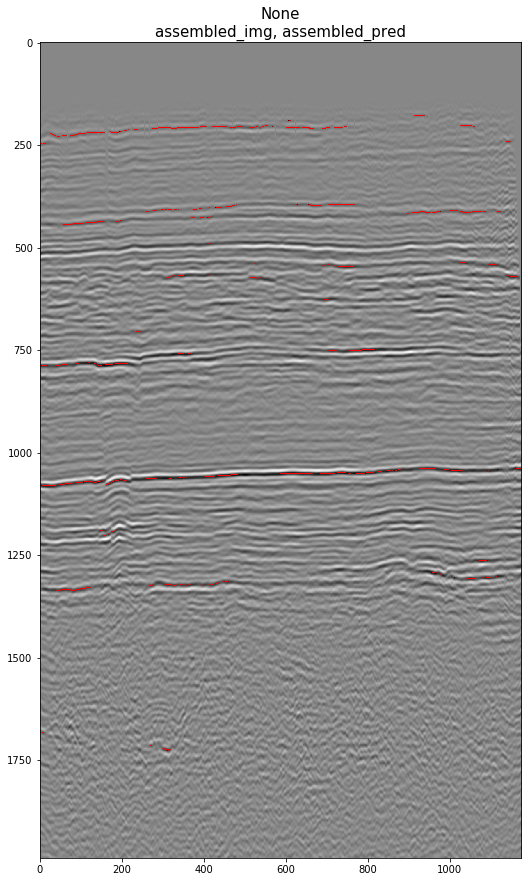


100%|██████████| 2/2 [00:00<00:00, 11.88it/s]


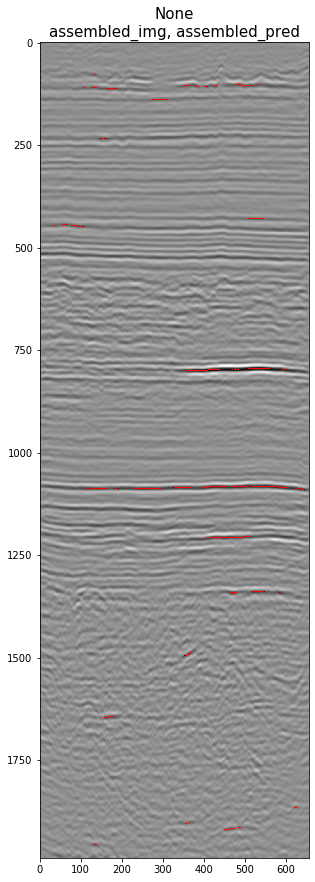


100%|██████████| 2/2 [00:00<00:00, 11.98it/s]


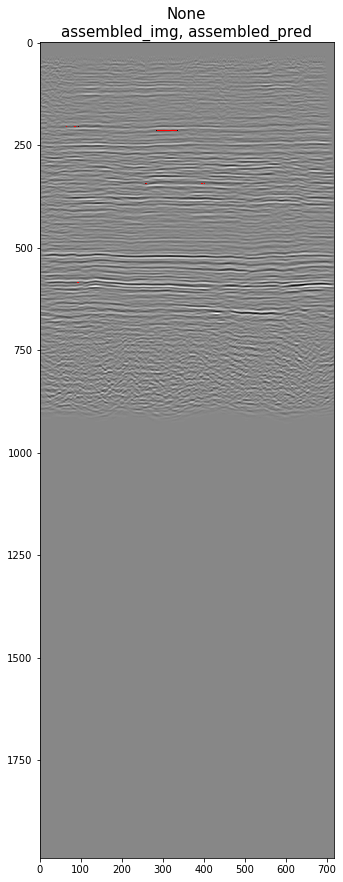


100%|██████████| 2/2 [00:00<00:00, 11.90it/s]


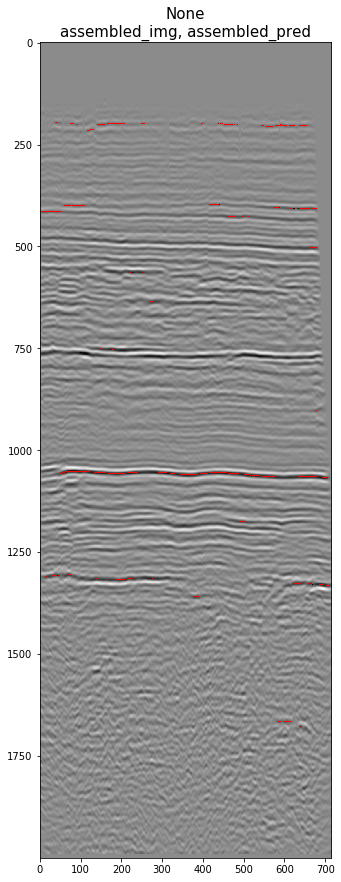


100%|██████████| 2/2 [00:00<00:00, 12.18it/s]


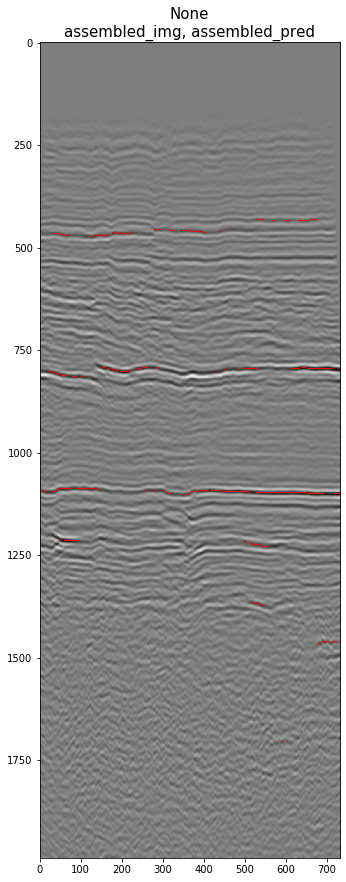


100%|██████████| 4/4 [00:00<00:00, 10.81it/s]


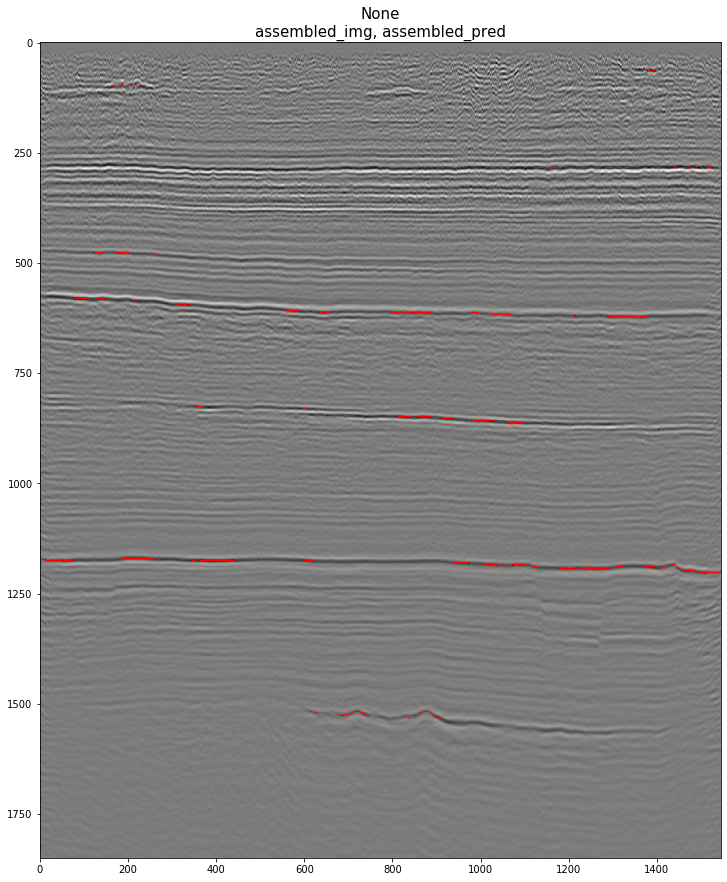

In [194]:
for i in range(len(test_ds)):
    shape = test_ds.geometries[test_ds.indices[i]].cube_shape
    test_ds.make_grid(test_ds.indices[i], CROP_SHAPE,
                      [0, shape[0]], [0, shape[1]], [0, shape[2]])

    val_pipeline = val_template << test_ds
    for _ in trange(test_ds.grid_iters):
        batch = val_pipeline.next_batch(D('size'), n_epochs=None)
    batch.plot_components('assembled_img', 'assembled_pred', idx=None, order_axes=(1, 2, 0))